In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Required Libraries**

In [ ]:
import torch
import numpy as np
import pandas as pd

from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_scheduler
)
from torch.optim import AdamW

from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns


# **Load IMDb Dataset (Hugging Face)**

In [ ]:
dataset = load_dataset("imdb")
dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

# **Small Subset (500 Samples)**

In [ ]:
# Combine train + test for random sampling
full_dataset = dataset["train"].shuffle(seed=42)

# Take 500 samples
small_dataset = full_dataset.select(range(500))

small_dataset


Dataset({
    features: ['text', 'label'],
    num_rows: 500
})

# **Train–Validation Split**

In [ ]:
split = small_dataset.train_test_split(test_size=0.15, seed=42)

train_ds = split["train"]
val_ds = split["test"]

print("Train size:", len(train_ds))
print("Validation size:", len(val_ds))


Train size: 425
Validation size: 75


# **Load BERT Tokenizer**

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# **Tokenization Function**

In [ ]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )


# **Tokenize the Dataset**

In [ ]:
train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)


Map:   0%|          | 0/425 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

In [ ]:
train_ds = train_ds.remove_columns(["text"])
val_ds = val_ds.remove_columns(["text"])

train_ds.set_format("torch")
val_ds.set_format("torch")


# **Create DataLoaders**

In [ ]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)


# **Load BERT Model for Classification**

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# **Optimizer & Learning Rate Scheduler**

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)


# **Training Loop (Fine-Tuning BERT)**

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [ ]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # -------- TRAIN --------
    model.train()
    total_loss = 0
    preds, labels = [], []

    for batch in train_loader:
        # Rename 'label' to 'labels' as expected by BertForSequenceClassification
        if 'label' in batch: # Check if 'label' key exists before renaming
            batch['labels'] = batch.pop('label')

        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        labels.extend(batch["labels"].cpu().numpy())

    train_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(labels, preds)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # -------- VALIDATION --------
    model.eval()
    total_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            # Rename 'label' to 'labels' for validation batch too
            if 'label' in batch: # Check if 'label' key exists before renaming
                batch['labels'] = batch.pop('label')

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            total_loss += outputs.loss.item()
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            labels.extend(batch["labels"].cpu().numpy())

    val_loss = total_loss / len(val_loader)
    val_acc = accuracy_score(labels, preds)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")



Epoch 1/3
Train Loss: 0.6776 | Train Acc: 0.5835
Val Loss:   0.6402 | Val Acc:   0.5467

Epoch 2/3
Train Loss: 0.5835 | Train Acc: 0.7012
Val Loss:   0.5532 | Val Acc:   0.7333

Epoch 3/3
Train Loss: 0.4357 | Train Acc: 0.8306
Val Loss:   0.5040 | Val Acc:   0.7333


# **Final Evaluation (Confusion Matrix & Report)**

In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in val_loader:
        # Rename 'label' to 'labels' as expected by BertForSequenceClassification
        if 'label' in batch: # Check if 'label' key exists before renaming
            batch['labels'] = batch.pop('label')

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(batch["labels"].cpu().numpy())


# **Confusion Matrix**

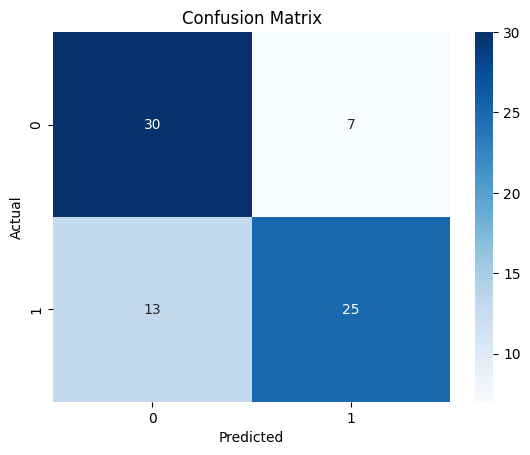

In [ ]:

cm = confusion_matrix(y_true, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# **Classification Report**

In [ ]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.81      0.75        37
           1       0.78      0.66      0.71        38

    accuracy                           0.73        75
   macro avg       0.74      0.73      0.73        75
weighted avg       0.74      0.73      0.73        75



# **Save & Load the Model**

In [ ]:
model.save_pretrained("bert_sentiment_model")
tokenizer.save_pretrained("bert_sentiment_model")


('bert_sentiment_model/tokenizer_config.json',
 'bert_sentiment_model/special_tokens_map.json',
 'bert_sentiment_model/vocab.txt',
 'bert_sentiment_model/added_tokens.json')